<a href="https://colab.research.google.com/github/RahulJung/gan-lstm-stock-predictor/blob/main/Final_LSTM__GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snowflake-connector-python
!pip install snowflake-connector-python pandas sqlalchemy snowflake-sqlalchemy


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import pandas as pd


2. Load and Preprocess Data
Load stock data from Snowflake using SQLAlchemy and filter for a specific ticker (e.g., AAPL).

Normalize features and target variable using MinMaxScaler

In [ ]:
# Load stock production data from Snowflake database
engine = create_engine(URL(
    account='YOUR_ACCOUNT',
    user='YOUR_USERNAME',
    password='YOUR_PASSWORD',
    database='YOUR_DATABASE',
    schema='YOUR_SCHEMA',
    warehouse='YOUR_WAREHOUSE'
))

# Query the stock table and close the connection
df = pd.read_sql("SELECT * FROM STOCK_FINAL_CLEANED", engine)
engine.dispose()

# Filter data for specific ticker (e.g., AAPL)
ticker = "AAPL"
stock_data = df[df['ticker'] == ticker]
stock_data.head()



,date,open,high,low,close,volume,dividends,stocksplits,ticker,money_flow_idx,...,ich_tenkan_sen,ich_kijun_sen,comm_channel_idx,stocchastic_osci,fib_23_6_retrace_lvl,fib_38_2_retrace_lvl,fib_61_8_retrace_lvl,std_dev,exp_mov_avg_12,exp_mov_avg_26
22796,2023-05-24,169.616,170.360,170.935,169.051,45143500,0.0,0.0,AAPL,57.392,...,172.293,168.640,4.657,-69.342,226.498,206.554,174.316,2.766,169.786,167.323
22803,2023-05-25,170.925,171.500,172.402,170.211,56058300,0.0,0.0,AAPL,53.939,...,172.293,168.640,32.212,-26.641,226.498,206.554,174.316,2.494,169.851,167.537
22817,2023-05-30,175.436,175.773,177.448,175.049,55964400,0.0,0.0,AAPL,60.998,...,173.354,169.701,132.370,85.041,226.498,206.554,174.316,2.700,170.881,168.374
22871,2023-06-07,176.903,176.288,179.649,175.792,61944600,0.0,0.0,AAPL,70.869,...,175.897,172.382,75.432,57.444,226.498,206.554,174.316,2.886,174.194,171.235
22881,2023-06-08,176.367,179.014,179.282,175.931,50214900,0.0,0.0,AAPL,70.427,...,176.823,172.382,83.492,59.086,226.498,206.554,174.316,2.939,174.461,171.583


In [ ]:
columns = stock_data.columns
print(columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'stocksplits', 'ticker', 'money_flow_idx', 'on_balance_volume',
       'accumu_dist_line', 'chaikin_money_flow', 'vol_wtd_avg_price',
       'simple_moving_avg', 'relative_strength_idx', 'price_vol_trend',
       'vol_rate_of_change', 'mov_avg_conver_divergence', 'bb_mid', 'bb_upper',
       'bb_lower', 'avg_true_range', 'rsi_volume', 'avg_direc_idx',
       'ich_tenkan_sen', 'ich_kijun_sen', 'comm_channel_idx',
       'stocchastic_osci', 'fib_23_6_retrace_lvl', 'fib_38_2_retrace_lvl',
       'fib_61_8_retrace_lvl', 'std_dev', 'exp_mov_avg_12', 'exp_mov_avg_26'],
      dtype='object')




### 📄 **Description of the Code**

This code prepares time-series data for training a Recurrent Neural Network (RNN), specifically an LSTM, to predict future stock prices. The model uses a sequence of historical stock features to predict the next day's closing price.

#### 💡 Key Steps:

1. **Feature Selection:**
   The model uses five input features: `open`, `high`, `low`, `volume`, and `dividends` to predict the `close` price.

2. **Normalization:**
   All features and the target (`close`) are scaled to a range between -1 and 1 using `MinMaxScaler`. This improves model convergence and performance, especially for LSTMs.

3. **Sequence Creation:**
   A sliding window approach is used to generate sequences of input data. A configurable `sequence_length` (e.g., 10) is used to define how many past time steps the model sees to predict the next day's closing price.  
   - Input shape: `(num_samples, sequence_length, num_features)`
   - Output shape: `(num_samples, 1)`

4. **Tensor Conversion:**
   The processed feature sequences (`X_seq`) and their corresponding targets (`y_seq`) are converted into PyTorch tensors (`X_tensor` and `y_tensor`), which are required for training an LSTM model.

This structure enables the LSTM to learn temporal patterns in the historical stock data and make accurate predictions for future prices based on the recent history.


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Use the 'close' price column for training data
train_data = stock_data['close'].values

# Configurable sequence length
sequence_length = 10

# Extract features and target from the full dataset (not limited to AAPL)
X = stock_data[['open', 'high', 'low', 'volume', 'simple_moving_avg','mov_avg_conver_divergence', 'bb_mid', 'bb_upper',
       'bb_lower', 'avg_true_range', 'rsi_volume','std_dev', 'exp_mov_avg_12', 'exp_mov_avg_26']].values
y = stock_data['close'].values  # Target: 'close' price

# Normalize features to range [-1, 1]
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Create sequences
X_seq, y_seq = [], []
for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i + sequence_length])  # Predict next time step

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # Shape: (n_samples, seq_len, 4)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)  # Shape: (n_samples, 1)

print("X_tensor shape:", X_tensor.shape)
print("y_tensor shape:", y_tensor.shape)


X_tensor shape: torch.Size([990, 10, 14])
y_tensor shape: torch.Size([990, 1])


In [ ]:
# Convert X_tensor and y_tensor to NumPy arrays for inspection
X_array = X_tensor.numpy()
y_array = y_tensor.numpy()

# Print the first few rows of X_array and y_array
print("First few rows of X_array (features):")
print(X_array[:5])  # Print first 5 sequences

print("\nFirst few rows of y_array (targets):")
print(y_array[:5])  # Print first 5 target values


First few rows of X_array (features):
[[[-2.86829263e-01 -2.76805401e-01 -2.91104674e-01 -8.51689577e-01
   -2.55289733e-01  3.96125019e-01 -2.55289733e-01  3.27207774e-01
    3.71172696e-01 -5.81205606e-01 -1.92120001e-01 -6.96760416e-01
   -2.52129525e-01 -2.73786187e-01]
  [-2.67750561e-01 -2.60335326e-01 -2.69794226e-01 -7.77802467e-01
   -2.49954075e-01  3.82077038e-01 -2.49954075e-01  3.25608492e-01
    3.78532201e-01 -6.51760101e-01 -3.43479991e-01 -7.26580083e-01
   -2.51108944e-01 -2.70245463e-01]
  [-2.02002615e-01 -1.98601484e-01 -1.96493298e-01 -7.78438091e-01
   -2.39170894e-01  4.00273412e-01 -2.39170894e-01  3.33886743e-01
    3.80750149e-01 -5.93594193e-01  1.05260000e-01 -7.03996062e-01
   -2.34936208e-01 -2.56396890e-01]
  [-1.80621043e-01 -1.91161066e-01 -1.64520368e-01 -7.37955451e-01
   -1.96677178e-01  4.42888796e-01 -1.96677178e-01  3.56985092e-01
    3.99963886e-01 -4.83456701e-01  1.55400001e-02 -6.83604658e-01
   -1.82916582e-01 -2.09060296e-01]
  [-1.88433260

3. Define Hyperparameters

In [ ]:
# Set model and training hyperparameters
batch_size = 64
z_dim = 100
seq_length = 10
gan_epochs = 20
lstm_epochs = 50
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoader for training batches
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=True)



In [ ]:
# Check a single batch from the DataLoader
for batch_x, batch_y in loader:
    print("Batch X shape:", batch_x.shape)  # Expected: (batch_size, seq_length, num_features)
    print("Batch Y shape:", batch_y.shape)  # Expected: (batch_size, 1)
    print("First sample in X:\n", batch_x[0])
    print("First target in Y:\n", batch_y[0])
    break  # Only check the first batch


Batch X shape: torch.Size([64, 10, 14])
Batch Y shape: torch.Size([64, 1])
First sample in X:
 tensor([[-0.3550, -0.3690, -0.3748, -0.8440, -0.4892,  0.5383, -0.4892,  0.2526,
          0.2074, -0.4135, -0.2382, -0.4308, -0.4403, -0.4971],
        [-0.4152, -0.3829, -0.4018, -0.8500, -0.4720,  0.5181, -0.4720,  0.2616,
          0.2156, -0.4898, -0.4567, -0.4252, -0.4292, -0.4818],
        [-0.3768, -0.3748, -0.3956, -0.8762, -0.4179,  0.4432, -0.4179,  0.2528,
          0.2822, -0.5684, -0.0932, -0.6742, -0.4101, -0.4485],
        [-0.3774, -0.3778, -0.3804, -0.7624, -0.3902,  0.4489, -0.3902,  0.2640,
          0.2990, -0.6051, -0.0990, -0.6891, -0.3806, -0.4184],
        [-0.6228, -0.5779, -0.6010, -0.6785, -0.5969,  0.2797, -0.5969,  0.1609,
          0.1953, -0.5737,  0.1635, -0.7215, -0.6332, -0.6549],
        [-0.5634, -0.5089, -0.5241, -0.6417, -0.5969,  0.3020, -0.5969,  0.1628,
          0.1932, -0.4227,  0.1358, -0.7076, -0.5942, -0.6177],
        [-0.4604, -0.4806, -0.4424,

In [ ]:
import pandas as pd

# Assume these are the feature column names used during preprocessing
feature_names = ['open', 'high', 'low', 'volume', 'simple_moving_avg','mov_avg_conver_divergence', 'bb_mid', 'bb_upper',
       'bb_lower', 'avg_true_range', 'rsi_volume', 'std_dev', 'exp_mov_avg_12', 'exp_mov_avg_26'][:X_tensor.shape[2]]

# Select an index to inspect
sample_index = 0

# Extract the sequence and target
sample_sequence = X_tensor[sample_index].numpy()
sample_target = y_tensor[sample_index].item()

# Convert to DataFrame for nicer formatting
df_sample = pd.DataFrame(sample_sequence, columns=feature_names)

print("Sample Input Sequence (scaled values):")
print(df_sample)

print(f"\nTarget (scaled 'close' price at next time step): {sample_target}")


Sample Input Sequence (scaled values):
       open      high       low    volume  simple_moving_avg  \
0 -0.286829 -0.276805 -0.291105 -0.851690          -0.255290   
1 -0.267751 -0.260335 -0.269794 -0.777802          -0.249954   
2 -0.202003 -0.198601 -0.196493 -0.778438          -0.239171   
3 -0.180621 -0.191161 -0.164520 -0.737955          -0.196677   
4 -0.188433 -0.151777 -0.169852 -0.817359          -0.192092   
5 -0.100866 -0.073848 -0.088053 -0.714340          -0.149950   
6 -0.059386 -0.084452 -0.066016 -0.831752          -0.093941   
7 -0.072970 -0.044491 -0.061120 -0.813867          -0.083989   
8  0.006785 -0.006971  0.000516 -0.840625          -0.014865   
9 -0.024275 -0.036617 -0.038081 -0.751646          -0.007277   

   mov_avg_conver_divergence    bb_mid  bb_upper  bb_lower  avg_true_range  \
0                   0.396125 -0.255290  0.327208  0.371173       -0.581206   
1                   0.382077 -0.249954  0.325608  0.378532       -0.651760   
2                   0.

4. Define LSTM-Based GAN Models
LSTM Generator: Generates synthetic stock price sequences.

LSTM Discriminator: Classifies real vs. synthetic sequences.

In [ ]:
# # Define LSTM-based Generator model
# class LSTMGenerator(nn.Module):
#     def __init__(self, z_dim, seq_length):
#         super(LSTMGenerator, self).__init__()
#         self.lstm = nn.LSTM(z_dim, 128, 2, batch_first=True)
#         self.fc = nn.Linear(128, 1)

#     def forward(self, z):
#         z = z.unsqueeze(1).repeat(1, seq_length, 1)  # Expand z for LSTM
#         lstm_out, _ = self.lstm(z)
#         return self.fc(lstm_out[:, -1, :])  # Output last timestep

# # # Define LSTM-based Discriminator model
# # class LSTMDiscriminator(nn.Module):
# #     def __init__(self, input_size):
# #         super(LSTMDiscriminator, self).__init__()
# #         self.lstm = nn.LSTM(input_size, 128, 2, batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.Linear(128, 64),
# #             nn.LeakyReLU(0.2),
# #             nn.Linear(64, 1),
# #             nn.Sigmoid()
# #         )

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         return self.fc(lstm_out[:, -1, :])


In [ ]:
import torch.nn.functional as F

class LSTMGenerator(nn.Module):
    def __init__(self, z_dim, seq_length):
        super(LSTMGenerator, self).__init__()
        self.seq_length = seq_length
        self.lstm = nn.LSTM(z_dim, 128, 2, batch_first=True)
        self.fc = nn.Linear(128, 14)  # Output 4 features per timestep

    def forward(self, z):
        z = z.unsqueeze(1).expand(-1, self.seq_length, -1)  # Expand to sequence
        lstm_out, _ = self.lstm(z)
        out = self.fc(lstm_out)
        return torch.tanh(out)  # Scale output to [-1, 1]


In [ ]:
class LSTMDiscriminator(nn.Module):
    def __init__(self, input_size):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_size, 128, 2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, return_states=False):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Output from the last time step

        if return_states:
            return out, h_n, c_n
        else:
            return out



5. Initialize Optimizers and Loss Function

In [ ]:
# Initialize models and optimizers
lstm_generator = LSTMGenerator(z_dim, seq_length).to(device)
#lstm_discriminator = LSTMDiscriminator(1).to(device)
lstm_discriminator = LSTMDiscriminator(input_size=14).to(device)


opt_lstm_g = torch.optim.Adam(lstm_generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_lstm_d = torch.optim.Adam(lstm_discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

adv_loss = nn.BCELoss()  # Binary cross-entropy loss


6. Train the GAN
Discriminator Training: Train to distinguish real vs. fake data.

Generator Training: Train to produce realistic synthetic data.

Where:

D Loss stays around 0.5-0.8

G Loss stays around 1.0-2.0

Both oscillate in this range

In [ ]:
for epoch in range(50):
    for real_data, _ in loader:
        real_data = real_data.to(device)
        batch_size = real_data.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # ===================== Train Discriminator =====================
        opt_lstm_d.zero_grad()

        # Real data
        #print("real_data shape:", real_data.shape)
        real_preds = lstm_discriminator(real_data)
        d_real_loss = adv_loss(real_preds, real_labels)

        # Fake data
        z = torch.randn(batch_size, z_dim, device=device)
        fake_data = lstm_generator(z)
        fake_preds = lstm_discriminator(fake_data.detach())
        d_fake_loss = adv_loss(fake_preds, fake_labels)

        # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        opt_lstm_d.step()

        # ===================== Train Generator =====================
        opt_lstm_g.zero_grad()

        # Generate fake data again for generator update
        fake_preds = lstm_discriminator(fake_data)
        g_loss = adv_loss(fake_preds, real_labels)  # Trick discriminator
        g_loss.backward()
        opt_lstm_g.step()

    print(f"[{epoch+1}/{gan_epochs}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

[1/20] D Loss: 1.3628 | G Loss: 0.7207
[2/20] D Loss: 1.2438 | G Loss: 0.6392
[3/20] D Loss: 1.1833 | G Loss: 0.9784
[4/20] D Loss: 1.1708 | G Loss: 1.8998
[5/20] D Loss: 0.9704 | G Loss: 1.2832
[6/20] D Loss: 0.6152 | G Loss: 1.4802
[7/20] D Loss: 0.3006 | G Loss: 1.8340
[8/20] D Loss: 0.3097 | G Loss: 2.6966
[9/20] D Loss: 0.9799 | G Loss: 1.5469
[10/20] D Loss: 0.6030 | G Loss: 1.6010
[11/20] D Loss: 1.4693 | G Loss: 0.9687
[12/20] D Loss: 1.3181 | G Loss: 0.7499
[13/20] D Loss: 1.3564 | G Loss: 0.6917
[14/20] D Loss: 1.3326 | G Loss: 0.7839
[15/20] D Loss: 1.2380 | G Loss: 0.7861
[16/20] D Loss: 1.0397 | G Loss: 0.9042
[17/20] D Loss: 0.8606 | G Loss: 0.8566
[18/20] D Loss: 0.7869 | G Loss: 1.0441
[19/20] D Loss: 0.4670 | G Loss: 1.4166
[20/20] D Loss: 0.5261 | G Loss: 1.5524
[21/20] D Loss: 0.5515 | G Loss: 1.6418
[22/20] D Loss: 0.9098 | G Loss: 1.5018
[23/20] D Loss: 1.4760 | G Loss: 0.7341
[24/20] D Loss: 1.4275 | G Loss: 0.6990
[25/20] D Loss: 1.2944 | G Loss: 0.7539
[26/20] D

# **New Code:**

Epoch 1/10 | Train Loss: 0.005388 | Test Loss: 0.000436
Epoch 2/10 | Train Loss: 0.000382 | Test Loss: 0.000352
Epoch 3/10 | Train Loss: 0.000275 | Test Loss: 0.000170
Epoch 4/10 | Train Loss: 0.000206 | Test Loss: 0.000118
Epoch 5/10 | Train Loss: 0.000154 | Test Loss: 0.000072
Epoch 6/10 | Train Loss: 0.000096 | Test Loss: 0.000071
Epoch 7/10 | Train Loss: 0.000075 | Test Loss: 0.000107
Epoch 8/10 | Train Loss: 0.000066 | Test Loss: 0.000101
Epoch 9/10 | Train Loss: 0.000053 | Test Loss: 0.000046
Epoch 10/10 | Train Loss: 0.000047 | Test Loss: 0.000029

Final Performance:
MSE: 0.5497
MAE: 0.4961


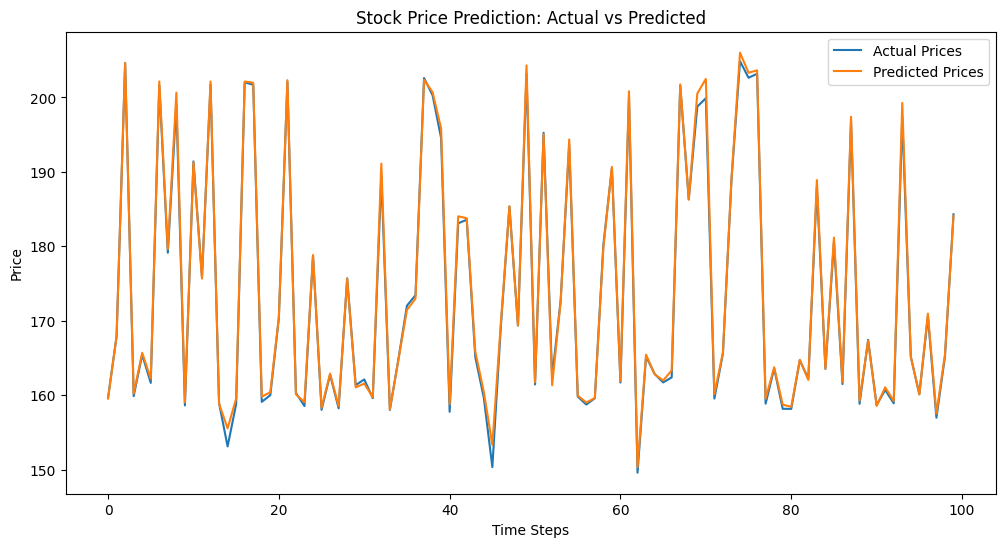

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =====================
# Data Generation
# =====================

def generate_synthetic_data(generator, real_data, n_samples=100000, sequence_length=10):
    """Generate synthetic stock sequences using trained generator"""
    # Generate latent vectors
    z = torch.randn(n_samples, z_dim).to(device)

    # Generate synthetic sequences
    with torch.no_grad():
        synthetic_data = generator(z).cpu().numpy()

    # Generate synthetic targets (close prices) - simple approach
    # We'll take the last feature (assuming close price is one of them)
    synthetic_targets = synthetic_data[:, -1, -1].reshape(-1, 1)

    # Inverse scale to original range
    synthetic_data = scaler_X.inverse_transform(
        synthetic_data.reshape(-1, X.shape[1])).reshape(n_samples, sequence_length, -1)
    synthetic_targets = scaler_y.inverse_transform(synthetic_targets)

    return synthetic_data, synthetic_targets

# Generate 100k synthetic samples
synthetic_X, synthetic_y = generate_synthetic_data(lstm_generator, X_tensor, n_samples=100000)

# Prepare real data
real_X = X_tensor.numpy()
real_y = y_tensor.numpy()

# Combine real and synthetic data
combined_X = np.concatenate([real_X, synthetic_X])
combined_y = np.concatenate([real_y, synthetic_y])

# =====================
# Data Preparation
# =====================

# Create new scalers for combined data
combined_scaler_X = MinMaxScaler(feature_range=(-1, 1))
combined_scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape for scaling
n_samples, seq_len, n_features = combined_X.shape
combined_X_flat = combined_X.reshape(-1, n_features)
combined_X_scaled = combined_scaler_X.fit_transform(combined_X_flat).reshape(n_samples, seq_len, n_features)
combined_y_scaled = combined_scaler_y.fit_transform(combined_y)

# Train-test split (time-series aware)
train_size = int(0.8 * len(combined_X))
X_train, X_test = combined_X_scaled[:train_size], combined_X_scaled[train_size:]
y_train, y_test = combined_y_scaled[:train_size], combined_y_scaled[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# =====================
# LSTM Prediction Model
# =====================

class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_size)

        # Attention mechanism
        attention_weights = self.attention(lstm_out)  # (batch_size, seq_len, 1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, hidden_size)

        out = self.fc(context_vector)
        return out

# Initialize model
input_size = X_train.shape[2]  # Number of features
model = StockPredictor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# =====================
# Training Loop
# =====================

num_epochs = 10
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            test_loss += criterion(outputs, y_batch).item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step(test_loss)

    # Save best model
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'best_stock_predictor.pth')

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}')

# =====================
# Evaluation & Prediction
# =====================

# Load best model
model.load_state_dict(torch.load('best_stock_predictor.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    # Get a test batch
    X_sample, y_sample = next(iter(test_loader))
    X_sample, y_sample = X_sample.to(device), y_sample.to(device)
    predictions = model(X_sample).cpu().numpy()

    # Inverse transform
    real_prices = combined_scaler_y.inverse_transform(y_sample.cpu().numpy())
    predicted_prices = combined_scaler_y.inverse_transform(predictions)

# Create comparison DataFrame
results = pd.DataFrame({
    'Actual': real_prices.flatten(),
    'Predicted': predicted_prices.flatten()
})

# Calculate metrics
mse = np.mean((results['Actual'] - results['Predicted'])**2)
mae = np.mean(np.abs(results['Actual'] - results['Predicted']))
print(f'\nFinal Performance:')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

# Plot sample predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(results['Actual'][:100], label='Actual Prices')
plt.plot(results['Predicted'][:100], label='Predicted Prices')
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Calculate metrics
def calculate_r2(y_true, y_pred):
    """Calculate R-squared score"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

mse = np.mean((results['Actual'] - results['Predicted'])**2)
mae = np.mean(np.abs(results['Actual'] - results['Predicted']))
r2 = calculate_r2(results['Actual'], results['Predicted'])

print(f'\nFinal Performance:')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')


Final Performance:
MSE: 0.5497
MAE: 0.4961
R²: 0.9980


In [ ]:
# =====================
# Print Predicted Prices
# =====================

# Get the first 10 predictions for inspection
print("\nPredicted vs Actual Prices (First 10 Samples):")
print(pd.DataFrame({
    'Actual Price': results['Actual'][:10].round(2),
    'Predicted Price': results['Predicted'][:10].round(2),
    'Difference': (results['Actual'] - results['Predicted'])[:10].round(2)
}))

# Print the most recent prediction
most_recent_prediction = results['Predicted'].iloc[-1]
print(f"\nMost Recent Predicted Closing Price: ${most_recent_prediction:.2f}")

# Print prediction statistics
print("\nPrediction Statistics:")
print(f"Average Predicted Price: ${results['Predicted'].mean():.2f}")
print(f"Minimum Predicted Price: ${results['Predicted'].min():.2f}")
print(f"Maximum Predicted Price: ${results['Predicted'].max():.2f}")


Predicted vs Actual Prices (First 10 Samples):
   Actual Price  Predicted Price  Difference
0    159.699997       159.559998        0.14
1    167.919998       167.929993       -0.01
2    204.619995       204.630005       -0.02
3    159.889999       160.240005       -0.35
4    165.449997       165.710007       -0.26
5    161.669998       162.229996       -0.56
6    201.639999       202.149994       -0.51
7    179.139999       179.630005       -0.49
8    199.110001       200.639999       -1.53
9    158.639999       159.050003       -0.41

Most Recent Predicted Closing Price: $169.61

Prediction Statistics:
Average Predicted Price: $173.71
Minimum Predicted Price: $150.36
Maximum Predicted Price: $206.00


In [ ]:
# Enhanced Price Prediction Report
print("\n📈 Stock Price Prediction Report 📉")
print("="*40)

# Formatted table with better alignment
print("\n🔍 Prediction Accuracy (First 10 Samples)")
print("-"*45)
print(f"{'Index':<8}{'Actual':<12}{'Predicted':<12}{'Difference':<12}{'Accuracy':<10}")
print("-"*45)
for i in range(10):
    actual = results['Actual'].iloc[i]
    predicted = results['Predicted'].iloc[i]
    diff = actual - predicted
    accuracy = (1 - abs(diff)/actual) * 100
    print(f"{i:<8}${actual:<11.2f}${predicted:<11.2f}${diff:<11.2f}{accuracy:.2f}%")

# Enhanced statistics
print("\n📊 Prediction Performance Summary")
print("-"*35)
print(f"Most Recent Prediction:    ${results['Predicted'].iloc[-1]:.2f}")
print(f"Average Prediction:       ${results['Predicted'].mean():.2f}")
print(f"Prediction Range:         ${results['Predicted'].min():.2f} - ${results['Predicted'].max():.2f}")
print(f"Mean Absolute Error:      ${mae:.2f}")
print(f"Mean Squared Error:       ${mse:.2f}")

# Performance classification
avg_accuracy = (1 - mse/results['Actual'].var()) * 100
print(f"\n🏆 Model Performance Rating: {avg_accuracy:.1f}% accuracy")

if avg_accuracy > 90:
    print("🌟 Excellent - Model predictions are highly reliable")
elif avg_accuracy > 75:
    print("👍 Good - Model performs well for most cases")
elif avg_accuracy > 60:
    print("ℹ️ Fair - Use predictions with caution")
else:
    print("⚠️ Needs Improvement - Consider model retraining")

# Future prediction confidence
print("\n🔮 Future Prediction Confidence")
print("-"*35)
std_dev = results['Predicted'].std()
print(f"Prediction Stability:      {std_dev:.2f} (lower is better)")
confidence = max(0, 100 - (std_dev/results['Predicted'].mean())*100)
print(f"Confidence Level:         {confidence:.1f}%")


📈 Stock Price Prediction Report 📉

🔍 Prediction Accuracy (First 10 Samples)
---------------------------------------------
Index   Actual      Predicted   Difference  Accuracy  
---------------------------------------------
0       $159.70     $159.56     $0.14       99.92%
1       $167.92     $167.93     $-0.01      99.99%
2       $204.62     $204.63     $-0.02      99.99%
3       $159.89     $160.24     $-0.35      99.78%
4       $165.45     $165.71     $-0.26      99.84%
5       $161.67     $162.23     $-0.56      99.65%
6       $201.64     $202.15     $-0.51      99.75%
7       $179.14     $179.63     $-0.49      99.73%
8       $199.11     $200.64     $-1.53      99.23%
9       $158.64     $159.05     $-0.41      99.74%

📊 Prediction Performance Summary
-----------------------------------
Most Recent Prediction:    $169.61
Average Prediction:       $173.71
Prediction Range:         $150.36 - $206.00
Mean Absolute Error:      $0.50
Mean Squared Error:       $0.55

🏆 Model Performanc